# Set CUDA and python paths

In [1]:
RCNN_DIR = '/opt/py-faster-rcnn/'

import os
os.environ["PYTHONPATH"] = RCNN_DIR + 'caffe-fast-rcnn/python'

!sudo unlink /usr/local/cuda
!sudo ln -s /usr/local/cuda-7.5 /usr/local/cuda

# Set paths for Faster RCNN

In [2]:
import os.path as osp
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        
caffe_path = osp.join(RCNN_DIR, 'caffe-fast-rcnn', 'python')
add_path(caffe_path)

lib_path = osp.join(RCNN_DIR, 'lib')
add_path(lib_path)

# Import necessary libraries

In [3]:
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2

%matplotlib inline

# Define network, classes, GPU, and other parameters

In [4]:
NET = 'vgg16'  # Options: vgg16, zf

GPU = 0  # Set to GPU ID

CLASSES = ('__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 
            'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 
            'dog', 'horse', 'motorbike', 'person', 
            'pottedplant', 'sheep' 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16', 'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF', 'ZF_faster_rcnn_final.caffemodel')}

# Visualize detections made by network

In [5]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return
    
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                         bbox[2] - bbox[0],
                         bbox[3] - bbox[1], fill=False,
                         edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                   fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

# Run demo with image(s)

In [6]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object 
       proposals."""
    
    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)
    
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
        '{:d} object proposals').format(timer.total_time, boxes.shape[0])
    
    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

# Main function



Loaded network /opt/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for x5.jpg
Detection took 0.229s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for multiple.jpg
Detection took 0.138s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for multiple2.jpg
Detection took 0.158s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for rear1.jpg
Detection took 0.182s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for angles.jpg
Detection took 0.152s for 271 object proposals


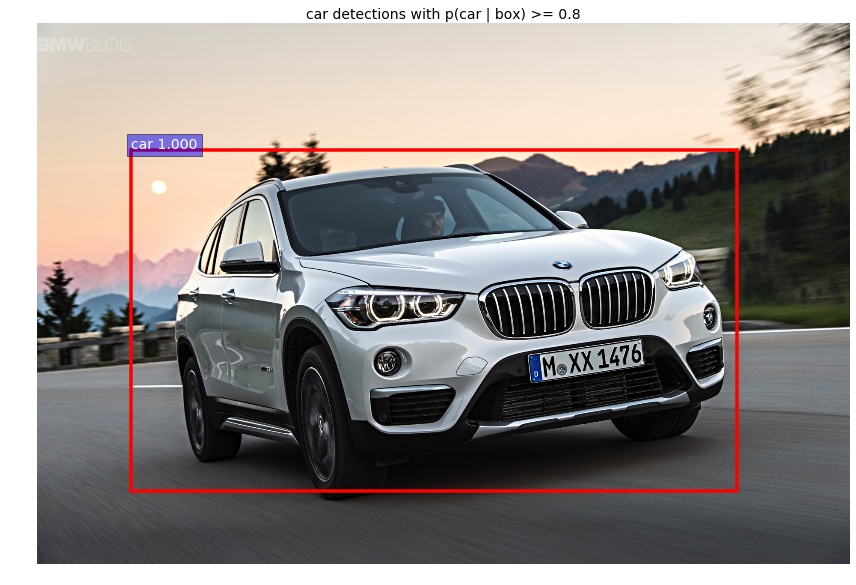

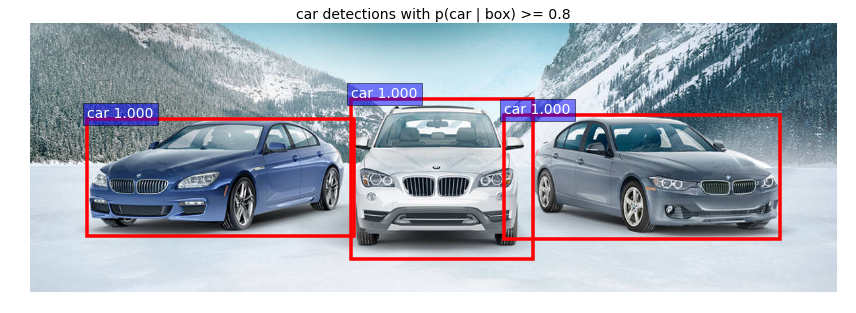

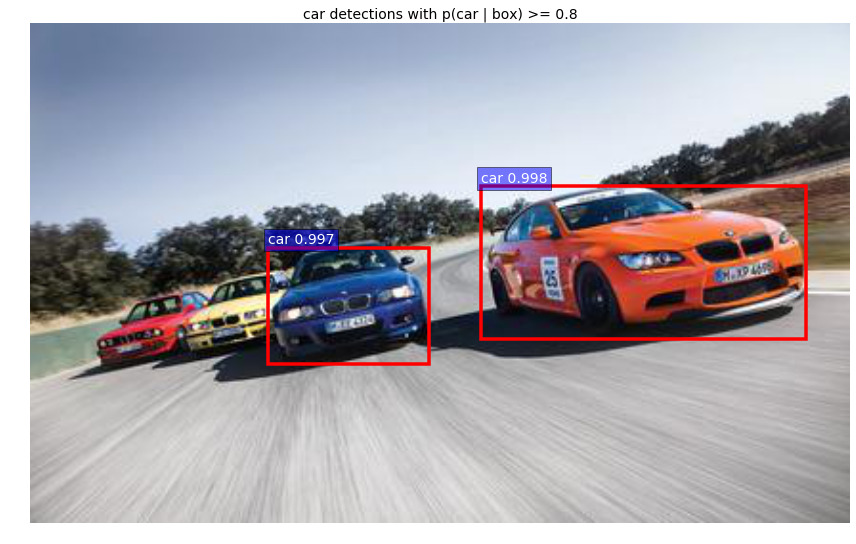

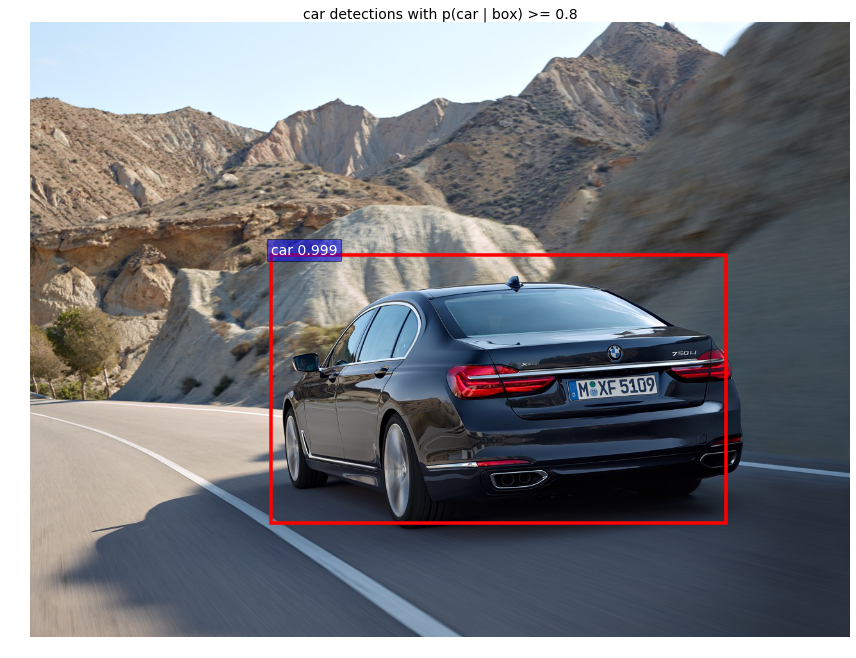

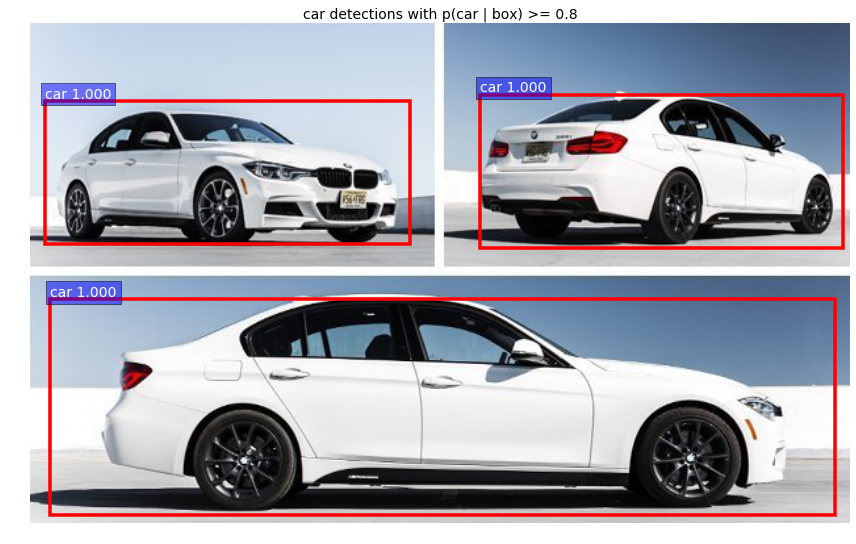

In [7]:
if __name__ == '__main__':
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals
    
    prototxt = os.path.join(cfg.MODELS_DIR, NETS[NET][0],
                           'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')
    caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                             NETS[NET][1])
    
    if not os.path.isfile(caffemodel):
        raise IOError(('{:s} not found.\nDid you run ./data/scripts/'
                      'fetch_faster_rcnn_models.sh?').format(caffemodel))
        
    caffe.set_mode_gpu()
    caffe.set_device(GPU)
    cfg.GPU_ID = GPU
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)
    
    print '\n\nLoaded network {:s}'.format(caffemodel)
    
    # Warmup on a dummy image
    im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
    for i in xrange(2):
        _, _ = im_detect(net, im)
        
    # List of image names to run
    im_names = ['x5.jpg', 'multiple.jpg', 'multiple2.jpg', 'rear1.jpg', 'angles.jpg']
    
    # Run demo script for each image
    for im_name in im_names:
        print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
        print 'Demo for {}'.format(im_name)
        demo(net, im_name)
        
    plt.show()